In [304]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(color_codes=True)
sns.set(context='talk')


# this is horrible voodoo to get deprecation warnings to stop
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

    
# load data
with open("data/processed_data.pickle", "rb") as f:
    (
        df_crypto,
        crypto_output_6_covariates,
        crypto_input_6_covariates,
        crypto_output_24_covariates,
        crypto_input_24_covariates,
        df_provide,
        provide_output_36_covariates,
        provide_input_36_covariates,
        provide_output_60_covariates,
        provide_input_60_covariates,
        names_of_covariate_groups
    ) = pickle.load(f)

# load results and models
N_SPLITS_OUTER = 25
with open('data/ml_results.pickle', 'rb') as f:
    all_results = pickle.load(f)

In [305]:
def drop_the_right_rows(df, output_covariate, covariates_to_check='raw_fnirs'):
    # first drop the rows where there is no output
    df = df.copy()
    df = df.loc[~pd.isnull(df[output_covariate]), :]
    # now drop rows where all of the fnirs are missing
    covariate_missing_flag = df[covariates_to_check].isnull().all(1)
    df = df.loc[~covariate_missing_flag, :]
    return df

<Figure size 1152x720 with 0 Axes>

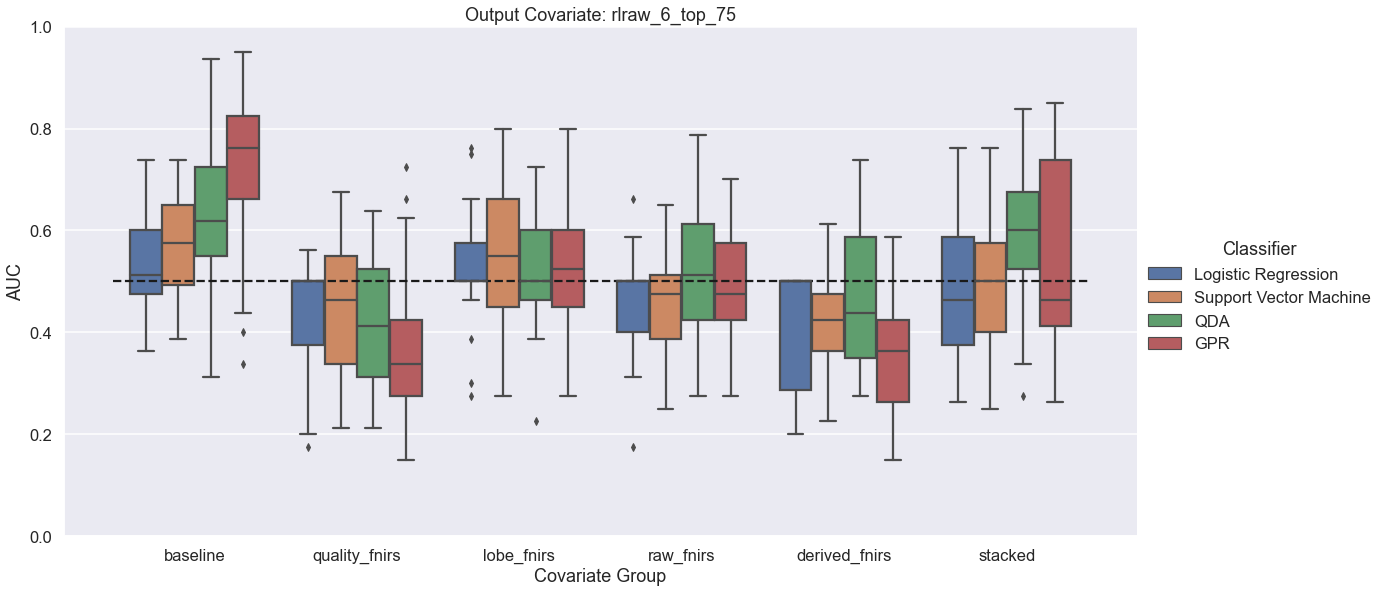

<Figure size 1152x720 with 0 Axes>

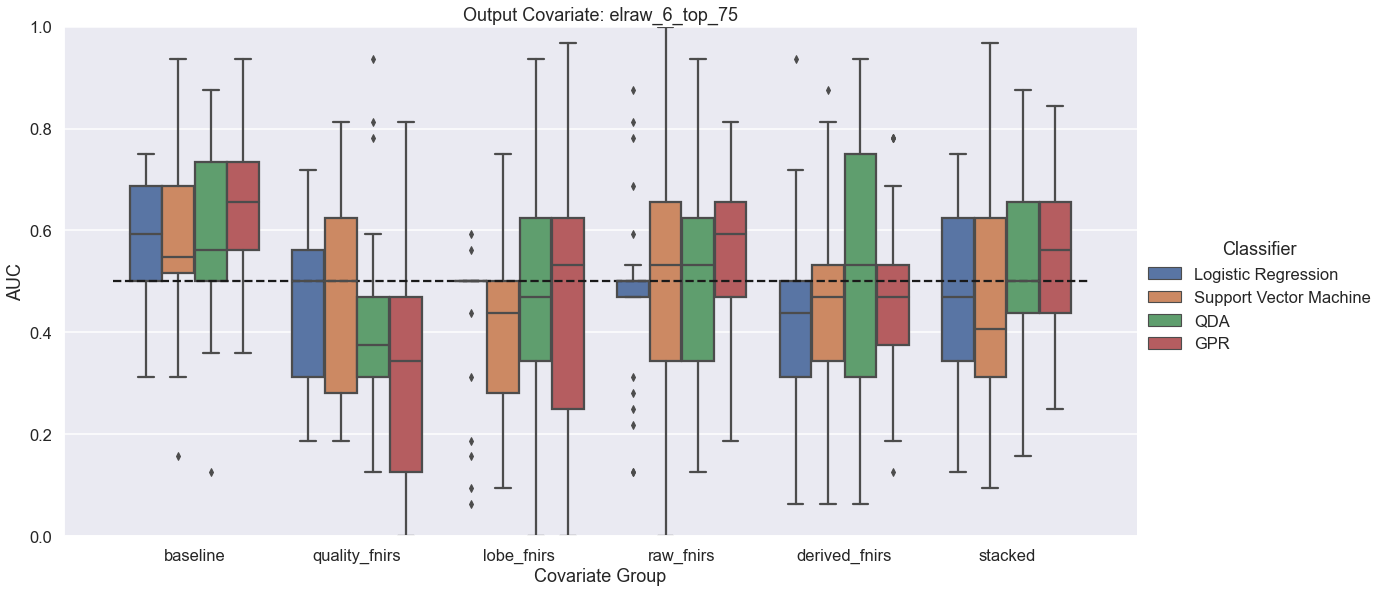

<Figure size 1152x720 with 0 Axes>

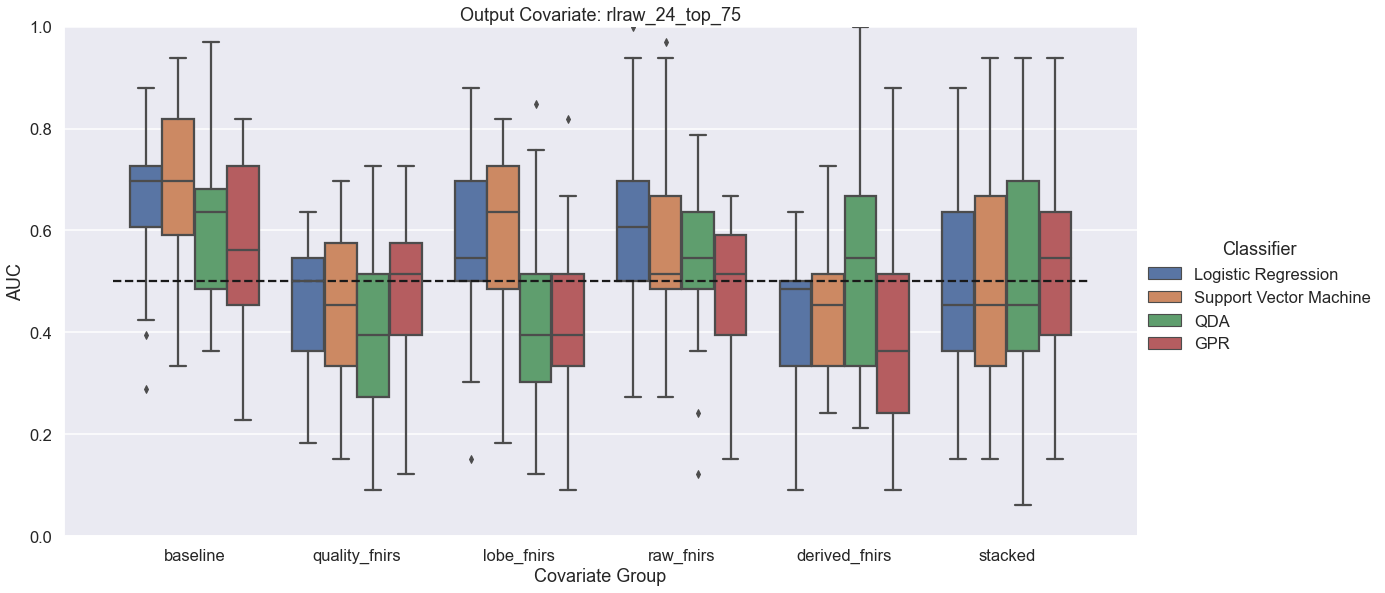

<Figure size 1152x720 with 0 Axes>

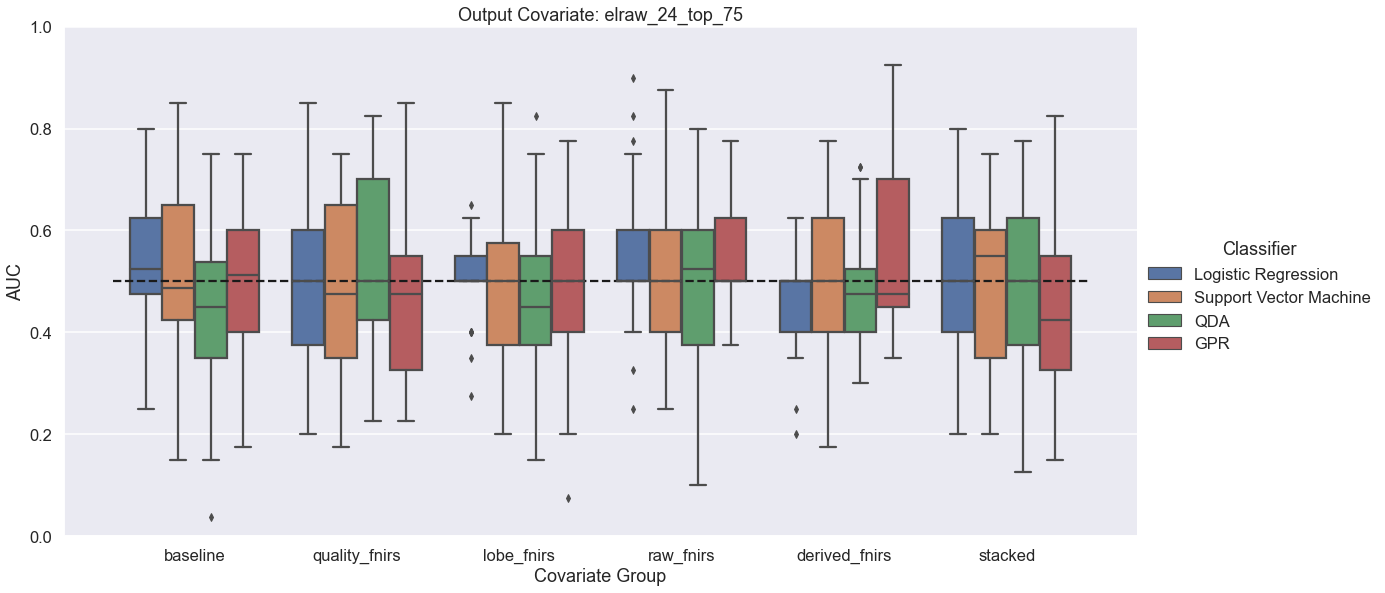

<Figure size 1152x720 with 0 Axes>

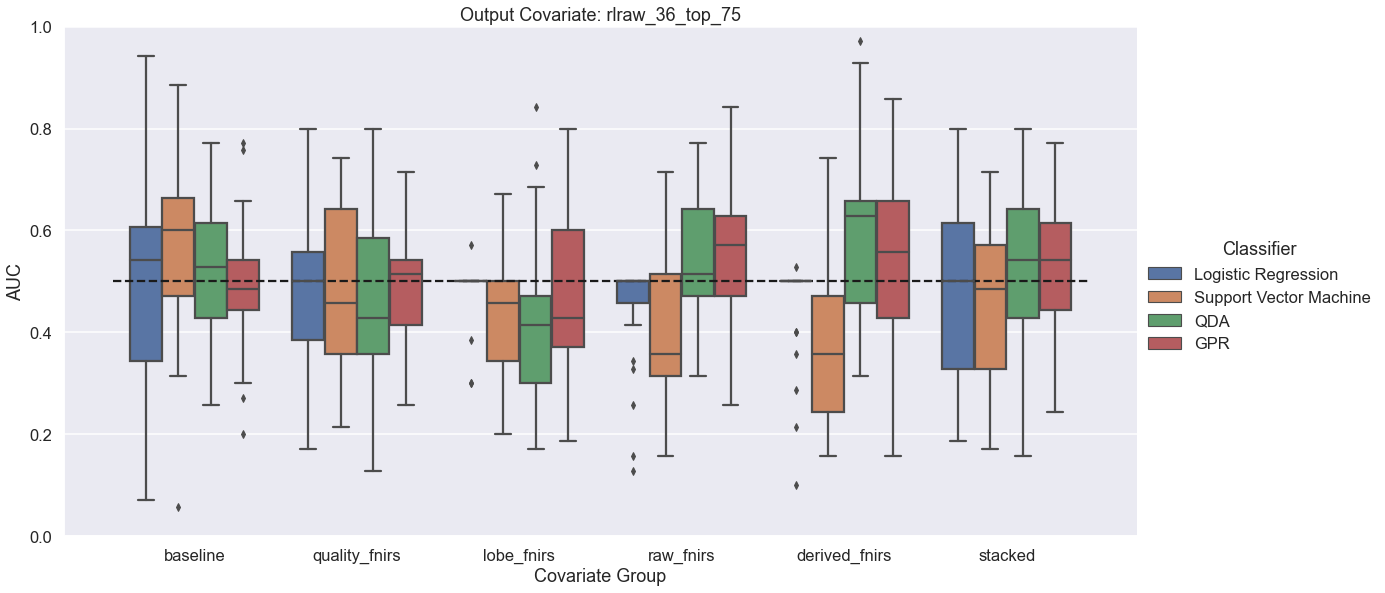

<Figure size 1152x720 with 0 Axes>

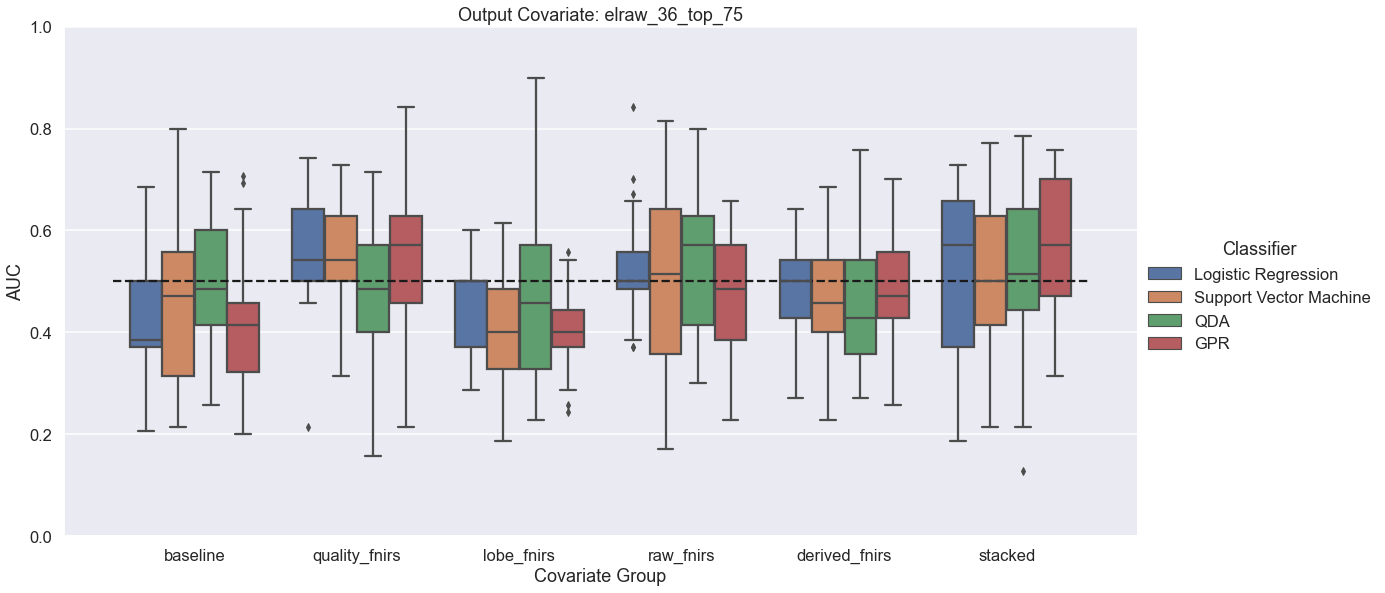

<Figure size 1152x720 with 0 Axes>

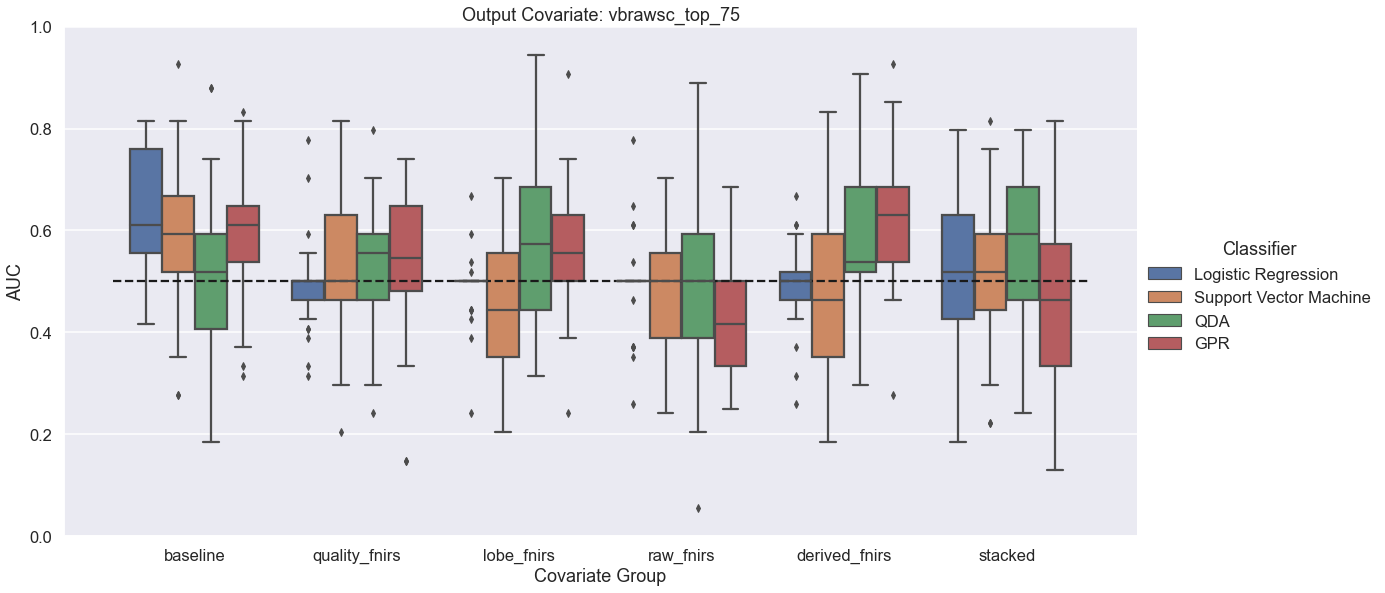

<Figure size 1152x720 with 0 Axes>

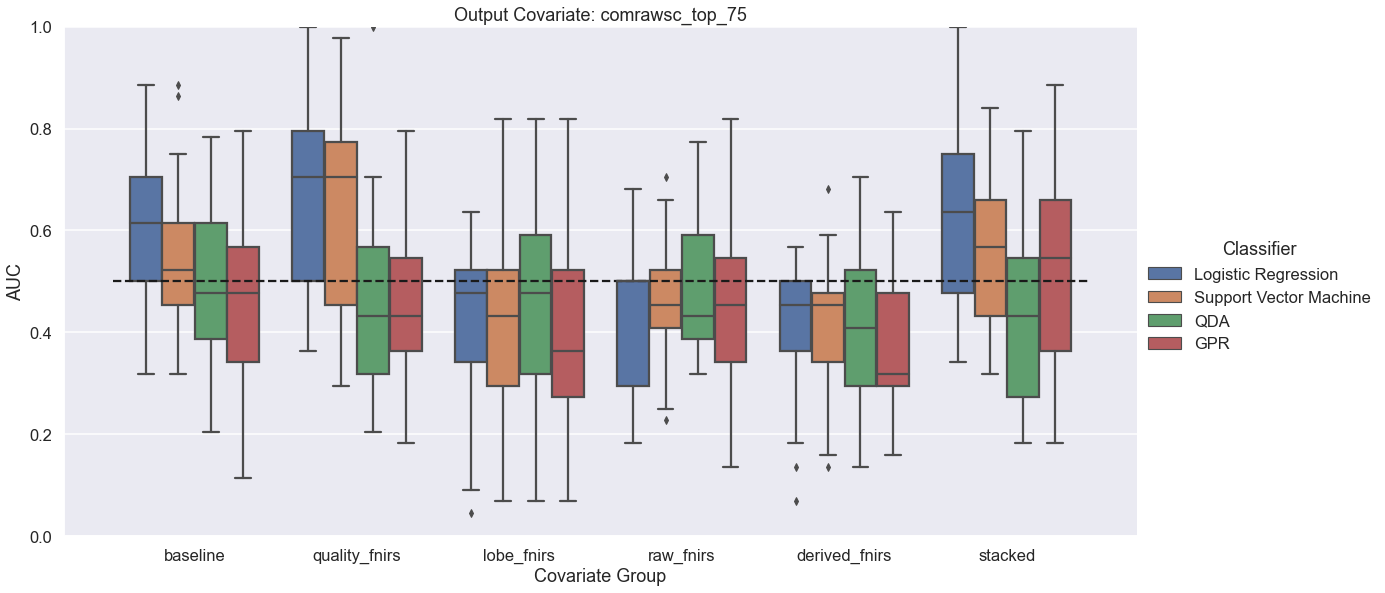

In [306]:
for output_variable in all_results.keys():
    results, outer_cv, df_displays = all_results[output_variable]
    for df in df_displays:
        df['model'] = df.index.name

    df = pd.concat(df_displays, 0).reset_index()
    df.columns = ['Covariate Group', 'Average AUROC (over 4 folds)', 'Standard Deviation AUROC (over 4 folds)', 'Classifier']

    def grouped_barplot(df, cat, subcat, val, err, title):
        u = df[cat].unique()
        x = np.arange(len(u))
        subx = df[subcat].unique()
        offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
        width= np.diff(offsets).mean()
        for i, gr in enumerate(subx):
            dfg = df[df[subcat] == gr]
            plt.bar(x+offsets[i], dfg[val].values, width=width, 
                    label="{}: {}".format(subcat, gr), yerr=dfg[err].values)
        plt.plot([-0.5, 5.5], [0.5, 0.5], '--', c='k', label='Random Performance')
        plt.xlabel(cat)
        plt.ylim(0, 1)
        plt.ylabel(val)
        plt.xticks(x, u)
        plt.legend()
        plt.title(title)
        plt.show()

    plt.figure(figsize=(16, 10))
    auc = []
    model = []
    feature_names = []
    
    for key, value in results.items():
        model += [key] * 6 * N_SPLITS_OUTER
        x = value['test_score']
        for i in range(N_SPLITS_OUTER):
            auc += list(x[i, :])
            feature_names += ['baseline', 'quality_fnirs', 'lobe_fnirs', 'raw_fnirs', 'derived_fnirs', 'stacked']

    df_boxplot = pd.DataFrame({
        'Classifier': model,
        'AUC': auc,
        'Covariate Group': feature_names
    })

    title=f'Output Covariate: {output_variable}'
    sns.catplot(x="Covariate Group", y="AUC", hue="Classifier",  data=df_boxplot, kind="box", dodge=True, height=8, aspect=2);
    plt.plot([-0.5, 5.5], [0.5, 0.5], '--', c='k', label='Random Performance');
    plt.ylim(0, 1)
    plt.title(title)
    #grouped_barplot(df, df.columns[0], df.columns[3], df.columns[1], df.columns[2], title=title)

In [307]:
# below is some example code of how to plot individual coefficients if one needs to for a linear model

# there is also curiously high-quality performance for predicting comrawsc_top_75 from quality fnirs
# rlraw_24_top_75 has high performance for both SVM and logistic regression. what are these coefficients?
results, outer_cv, df_displays = all_results['rlraw_6_top_75']

models = results["Support Vector Machine"]["estimator"]

# for each SVM, we need to figure out: 
# (a) which columns were selected
# (b) which columns were appended from the imputer
# (c) which columns were dropped by the selector
# (d) coefficients of what's left

dfs = []
covariate_index = names_of_covariate_groups.index('baseline')
for _, model in [i[covariate_index] for i in models]:

    column_selector = model.steps[0][1]
    imputer = model.steps[2][1]
    imputers_indicators = imputer.indicator_.features_
    selector = model.steps[3][1]
    lr = model.steps[4][1]
    
    starting_cols = column_selector.cols
    if len(imputers_indicators) > 0:
        starting_cols = list(starting_cols) + [starting_cols[i] + '_missing_indicator' for i in imputers_indicators] 
        starting_cols = np.array(starting_cols)
        
    selected_cols = np.array(starting_cols)[selector.get_support()]
    
    print(selector.percentile)
    
#     coefs = lr.coef_[0]
    
#     df = pd.DataFrame({
#         'Input Covariate': selected_cols,
#         "Logistic Regression Coefficient (normalized)": coefs / np.nanmax(coefs),
#         'Split Number': [i] * len(coefs)
#     })
    
#     dfs.append(df)
#     i += 1
    
# df_all = pd.concat(dfs)


# plt.figure(figsize=(16, 66))
# sns.barplot(y = "Input Covariate", x = "Logistic Regression Coefficient (normalized)", hue = "Split Number", data = df_all)
# plt.tight_layout()
# plt.title("GPR fNIRS Quality Coefficients for Predicting comrawsc_top_75")
# plt.show()


10
5
10
10
5
100
10
10
10
10
10
10
10
100
10
10
5
10
5
100
100
100
5
100
5
